## Построение скоринговых моделей с использованием методов машинного обучения

Кредитный скоринг - система оценки кредитоспособности (кредитных рисков) лица, основанная на численных статистических методах. Как правило, используется в потребительском  экспресс-кредитовании на небольшие суммы. Также возможно его использование в бизнесе сотовых операторов, страховых компаний и т. д. Скоринг заключается в присвоении баллов по заполнению некой анкеты, разработанной оценщиками кредитных рисков андеррайтерами. По результатам набранных баллов системой принимается решение об одобрении или отказе в выдаче кредита.

Данные для скоринговых систем получаются из вероятностей возвратов кредитов отдельными группами заёмщиков, полученными из анализа кредитной истории тысяч людей. Считается, что существует корреляция между определенными социальными данными (наличие детей, отношение к браку, наличие высшего образования) и добросовестностью заемщика.

Является упрощённой системой анализа заёмщика, что позволяет упразднить субъективизм принятия решения кредитного инспектора, снижает уровень внутреннего мошенничества, увеличить скорость принятия решения по кредиту. Аналогичным способом скоринговая модель может позволять рассчитывать индивидуальную ставку по страховому продукту, устанавливая толерантность к риску.

Для банка очень важно правильно сегментировать клиентов, так как если клиента определить неправильно, то:

1. Хороший клиент, определенный как плохой - потерянный клиент для банка

2. Плохой клиент, определенный как хороший - потеря средств для банка (не возврат кредита)

3. Хороший клиент, переоцененный как очень хороший - неправильно выданный лимит, который клиент не сможет оплатить в силу своей низкой платеже способности.

4. Недооцененный клиент - потеря объемов выданных кредитов и прибыльности банка соответственно.

Увеличивая процент правильных решений по каждому конкретному клиенту, также увеличивается и операционная прибыль банка, поскольку банк из-за этого меньше теряет на "плохих" клиентах, и больше зарабатывает на "хороших", что позволяет коммерческой организации достигать новых высот в своей работе.


Источники:
    1. https://www.cfin.ru/finanalysis/banks/borrowing_capacity.shtml
    2. https://www.nbki.ru/poleznaya-informatsiya/scoringovaya-model-ocenki/
    3. https://naukovedenie.ru/PDF/180EVN214.pdf    

###### Импортируем библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif 
plt.rcParams['figure.figsize'] = [30, 30]
from matplotlib import colors

In [2]:
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)

###### Загружаем и анализируем данные

In [3]:
df = pd.read_csv('Train_Kaggle_CreditScoring_(1).csv', encoding='Windows-1251')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310704 entries, 0 to 310703
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   310704 non-null  int64  
 1   loan_amnt            310704 non-null  int64  
 2   funded_amnt          310704 non-null  int64  
 3   funded_amnt_inv      310704 non-null  float64
 4   term                 310704 non-null  object 
 5   int_rate             310704 non-null  float64
 6   installment          310704 non-null  float64
 7   grade                310704 non-null  object 
 8   emp_title            281139 non-null  object 
 9   emp_length           288089 non-null  object 
 10  home_ownership       310704 non-null  object 
 11  annual_inc           310704 non-null  float64
 12  verification_status  310704 non-null  object 
 13  issue_d              310704 non-null  object 
 14  purpose              310704 non-null  object 
 15  addr_state       

###### Представлены следующие данные:
* id - идентификатор
* loan_amnt - сумма кредита
* funded_amnt - общая сумма необходимого финансирования
* funded_amnt_inv - общая сумма финансирования инвесторами
* term - срок кредита
* int_rate - процентная ставка
* installment - ежемесячные взносы заемщика
* grade - кредитный рейтинг (с нарастанием риска от A к G) 
* emp_title - должность
* emp_length - стаж работы
* home_ownership - форма собственности жилья
* annual_inc - годовой доход
* verification_status - статус верификации предоставленных данных
* issue_d - дата обращения за кредитом
* purpose - цель кредита
* addr_state - регион проживания 
* dti - отношение долга к доходам
* delinq_2yrs - количество раз за последние 2 года, когда заемщик просрочил оплату более чем на 30 дней 
* earliest_cr_line - дата выдачи первого кредита 
* inq_last_6mths - количество обращений за кредитом за последние 6 месяцев
* open_acc - количество открытых кредитных линий  
* pub_rec - количество компрометирующих фактов 
* revol_bal - возобновляемый баланс заемщика  
* revol_util - коэффициент использования возобновляемой линии кредита
* total_acc - общее количество кредитных линий 
* out_prncp - непогашенная сумма основного долга
* total_pymnt - общая сумма платежей, полученная на сегодняшний день
* loan_status - статус займа (полностью погашен, просрочка, льготный период, списание, дефолт)
* risk - риск невозврата кредита

In [4]:
pd.set_option('display.max_columns', None)
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,total_pymnt,loan_status,risk
0,1,2500,2500,2500.0,36 months,13.56,84.92,C,Chef,10+ years,RENT,55000.0,Not Verified,Dec-18,debt_consolidation,CA,30.46,0,Jan-12,0.0,11,1,15603,37.0,19,0.0,30026.442500,Fully Paid,0
1,2,30000,30000,30000.0,60 months,18.94,777.23,D,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-18,credit_card,OH,50.53,0,Jun-09,0.0,18,0,34971,64.5,37,0.0,40856.678960,Fully Paid,0
2,3,5000,5000,5000.0,36 months,17.97,180.69,D,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-18,credit_card,WA,18.92,0,Feb-99,0.0,9,0,25416,29.9,19,0.0,20215.792430,Fully Paid,0
3,4,4000,4000,4000.0,36 months,18.94,146.51,D,IT Supervisor,10+ years,MORTGAGE,92000.0,Source Verified,Dec-18,credit_card,TX,4.64,0,Dec-03,0.0,12,0,4472,15.3,25,0.0,4549.217149,Fully Paid,0
4,5,30000,30000,30000.0,60 months,16.14,731.78,C,Mechanic,10+ years,MORTGAGE,57250.0,Not Verified,Dec-18,credit_card,MA,12.37,0,Oct-97,0.0,21,0,36812,65.7,37,0.0,8735.148975,Fully Paid,0


In [5]:
df.shape

(310704, 29)

###### Предобработка данных

In [6]:
df.describe()

,id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,total_pymnt,risk
count,3.107040e+05,310704.000000,310704.000000,310704.000000,310704.000000,310704.000000,3.107040e+05,310556.000000,310704.000000,310703.000000,310704.000000,310704.000000,3.107040e+05,310491.000000,310704.000000,310704.000000,310704.000000,310704.000000
mean,6.204661e+05,15518.606133,15518.606133,15511.817884,12.565801,452.838937,8.053998e+04,19.020776,0.338029,0.607374,11.882889,0.248008,1.605273e+04,48.495109,24.916757,723.861865,13430.483430,0.333655
std,3.928862e+05,9196.532109,9196.532109,9195.219672,4.702061,264.514016,9.286294e+04,12.339552,0.921206,0.888372,5.793843,0.671583,2.322824e+04,24.812508,12.312579,3602.732652,10010.944733,0.471519
min,1.000000e+00,1000.000000,1000.000000,725.000000,5.320000,14.770000,0.000000e+00,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000,0.000000
25%,7.767675e+04,8275.000000,8275.000000,8250.000000,8.810000,259.420000,4.800000e+04,12.070000,0.000000,0.000000,8.000000,0.000000,5.515750e+03,29.600000,16.000000,0.000000,5783.218540,0.000000
50%,7.586255e+05,14000.000000,14000.000000,14000.000000,11.990000,387.550000,6.720000e+04,18.190000,0.000000,0.000000,11.000000,0.000000,1.059000e+04,48.000000,23.000000,0.000000,10741.860000,0.000000
75%,9.708992e+05,20800.000000,20800.000000,20800.000000,15.310000,602.950000,9.500000e+04,25.080000,0.000000,1.000000,15.000000,0.000000,1.908500e+04,67.300000,32.000000,0.000000,18592.573820,1.000000
max,1.048575e+06,40000.000000,40000.000000,40000.000000,30.990000,1618.240000,9.757200e+06,999.000000,21.000000,5.000000,81.000000,86.000000,1.044210e+06,182.800000,176.000000,40000.000000,59808.262090,1.000000


In [7]:
df[['emp_title','emp_length','term','grade','home_ownership','verification_status','issue_d','purpose','addr_state','earliest_cr_line','loan_status']].describe()

,emp_title,emp_length,term,grade,home_ownership,verification_status,issue_d,purpose,addr_state,earliest_cr_line,loan_status
count,281139,288089,310704,310704,310704,310704,310704,310704,310704,310704,310704
unique,91590,11,2,7,4,3,9,13,50,682,6
top,Teacher,10+ years,36 months,B,MORTGAGE,Source Verified,Mar-16,debt_consolidation,CA,Sep-04,Fully Paid
freq,5670,102566,216036,92006,154329,125311,56649,177629,43550,2445,207036


*Удаляем дубликаты*

In [8]:
df.drop_duplicates(inplace=True)

*Исследуем на поля на наличие пропусков*

In [9]:
df.loc[:, df.columns[df.isnull().any()]].isnull().sum().sort_values(ascending = False)

emp_title         29565
emp_length        22615
revol_util          213
dti                 148
inq_last_6mths        1
dtype: int64

*Есть пропуски по следующим полям: должность,стаж работы, коэффициент использования возобновляемой кредитной линии, dti, количество обращений за кредитом за последние 6 месяцев*

In [10]:
round(df.isnull().mean()*100,2).sort_values(ascending = False).head()

emp_title     9.52
emp_length    7.28
revol_util    0.07
dti           0.05
risk          0.00
dtype: float64

*Максимальное количество пропусков в столбце должность.
Второе место по количеству пропусков занимает столбец стаж работы и составляет 7,28%. Пропуски по этому столбцу заполним модой в разрезе статусов займа. Остальные строки с пропусками удалим.*

In [11]:
df.groupby('loan_status')['emp_length'].apply(lambda x: x.mode())

loan_status          
Charged Off         0    10+ years
Default             0    10+ years
Fully Paid          0    10+ years
In Grace Period     0    10+ years
Late (16-30 days)   0    10+ years
Late (31-120 days)  0    10+ years
Name: emp_length, dtype: object

In [12]:
df.groupby('risk')['emp_length'].apply(lambda x: x.mode())

risk   
0     0    10+ years
1     0    10+ years
Name: emp_length, dtype: object

*Мода по категориям не отличается, поэтому заполним пропуски модой по столбцу*

In [13]:
df.emp_length.fillna(df.emp_length.mode()[0], inplace = True)

*По признаку emp_title (должность заемщика) данные нестандартизированы, преобразовывать в числовые не имеет смысла из-за очень большого количества уникальных значений. Отбросим этот столбец, но оставим флаг, была ли указана должность.*

In [14]:
df.emp_title = df.emp_title.fillna('NaN', inplace = False)

In [15]:
df['is_title_known'] = df['emp_title'].map(lambda x: 0 if x == 'NaN' else 1)
df.drop('emp_title', axis=1, inplace=True)

In [16]:
 df = df.dropna(axis=0)

*Пропусков значений больше нет*

In [17]:
df.loc[:, df.columns[df.isnull().any()]].isnull().sum().sort_values(ascending = False)

Series([], dtype: float64)

*Количество уникальных значений:*

In [18]:
df.nunique(dropna=False)

id                     310342
loan_amnt                1522
funded_amnt              1522
funded_amnt_inv          1542
term                        2
int_rate                  150
installment             37936
grade                       7
emp_length                 11
home_ownership              4
annual_inc              20857
verification_status         3
issue_d                     9
purpose                    13
addr_state                 50
dti                      5833
delinq_2yrs                22
earliest_cr_line          682
inq_last_6mths              6
open_acc                   70
pub_rec                    29
revol_bal               53862
revol_util               1160
total_acc                 127
out_prncp               17864
total_pymnt            299127
loan_status                 6
risk                        2
is_title_known              2
dtype: int64

In [19]:
# Переведем количество обращений за последние 6 месяцев в категориальную переменную
df.inq_last_6mths = df.inq_last_6mths.astype(object)

*Преобразуем даты в числовые переменные*

In [20]:
def month_to_decimal(month):
    month_dict = {'Jan':0, 'Feb':1/12., 'Mar':2/12., 'Apr':3/12., 'May':4/12., 'Jun':5/12., 
     'Jul':6/12., 'Aug':7/12., 'Sep':8/12., 'Oct':9/12., 'Nov':10/12., 'Dec':11/12.}
    return month_dict[month]

In [21]:
def convert_date(month_year):
    month_and_year = month_year.split('-')
    if int(month_and_year[1]) > 50:
        year = 1900 + int(month_and_year[1])
    else:
        year = 2000 + int(month_and_year[1])
    return float(year) + month_to_decimal(month_and_year[0])

In [22]:
df['issue_d'] = df['issue_d'].map(lambda x: convert_date(x))
df['earliest_cr_line'] = df['earliest_cr_line'].map(lambda x: convert_date(x))

In [23]:
num_cols = ['loan_amnt','funded_amnt','funded_amnt_inv','int_rate','installment','annual_inc','dti','delinq_2yrs','issue_d','earliest_cr_line','open_acc','pub_rec','revol_bal','revol_util','total_acc','out_prncp','total_pymnt']

*Исследуем данные на выбросы*

In [24]:
def detect_outliers(df):
    outlier_indices=[]
    for col in num_cols:
        Q1 = np.percentile(df[col].dropna(),25)
        Q3 = np.percentile(df[col].dropna(),75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < (Q1 - outlier_step))|(df[col] > (Q3 + outlier_step))].index
        if len(outlier_list_col)!=0:
            outlier_indices.append(col)
    return outlier_indices
    
outliers = detect_outliers(df)
print(outliers)

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'total_pymnt']


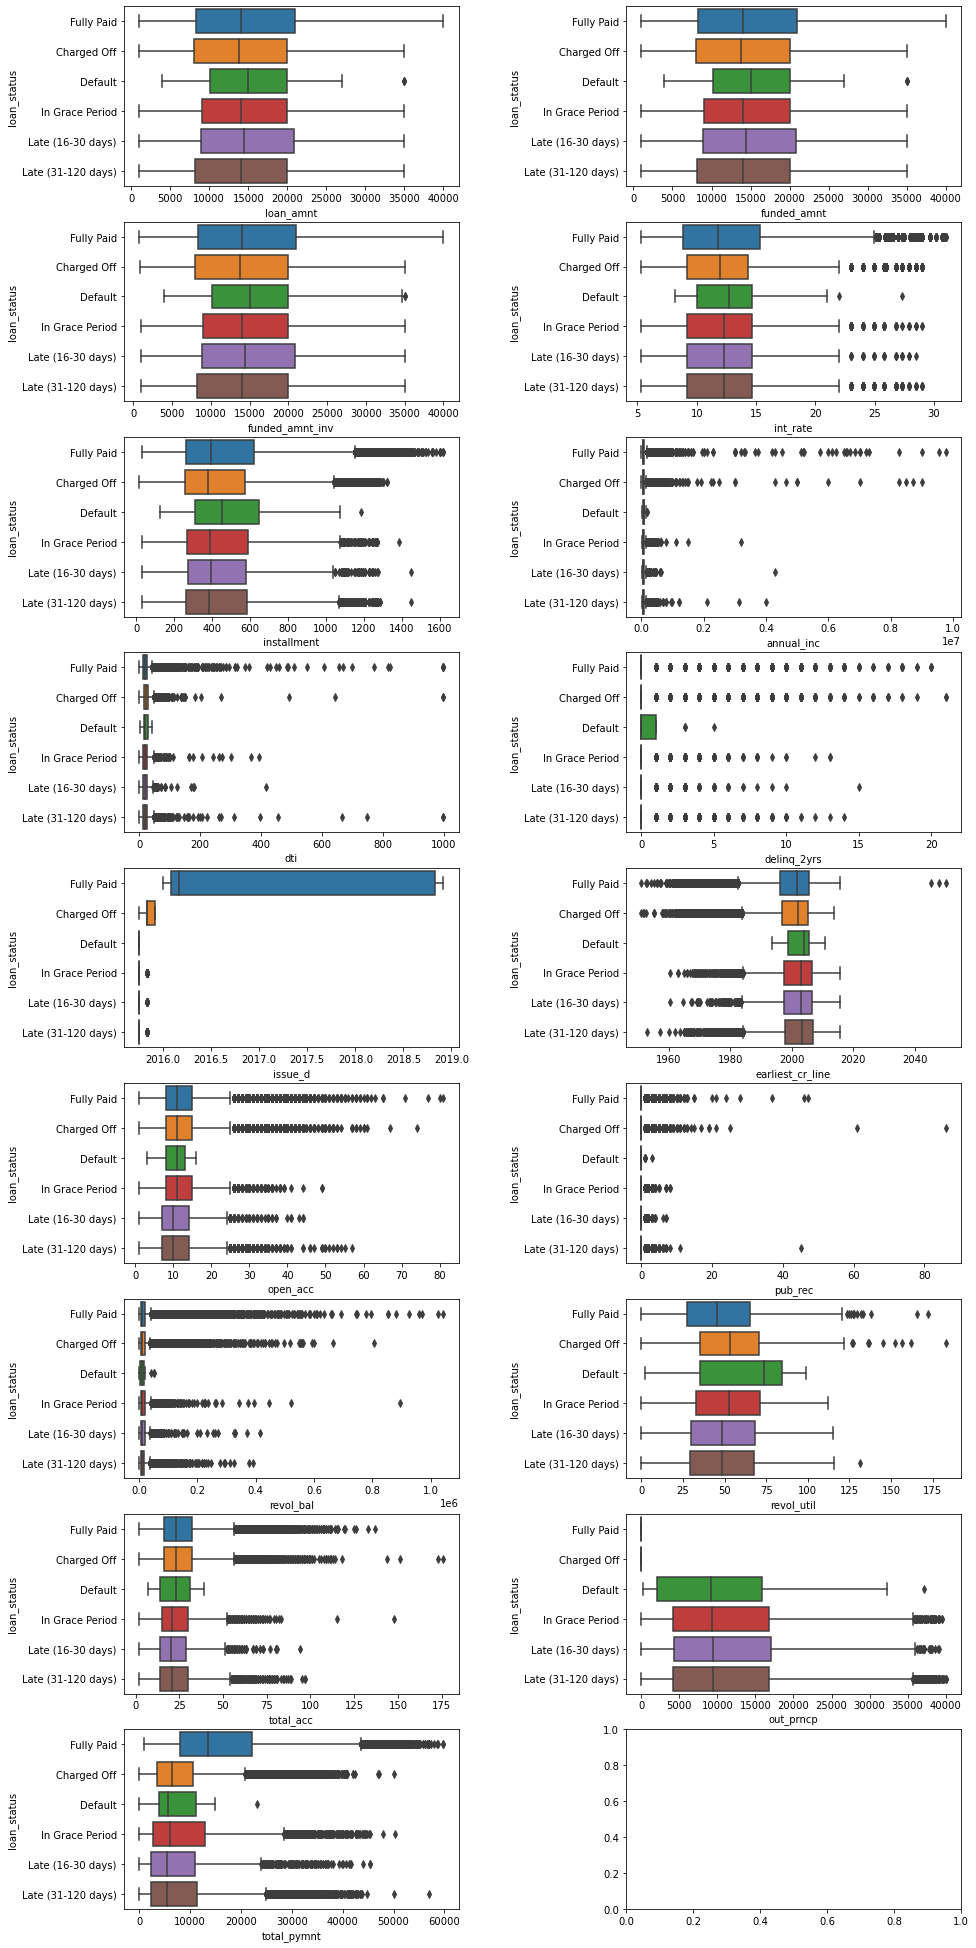

In [25]:
fig, axes = plt.subplots(9, 2, figsize = (15,35))
plt.subplots_adjust(wspace = 0.5)
axes = axes.flatten()
for i in range(len(num_cols)):
    sns.boxplot(x = num_cols[i], y = 'loan_status', data = df, ax = axes[i])    

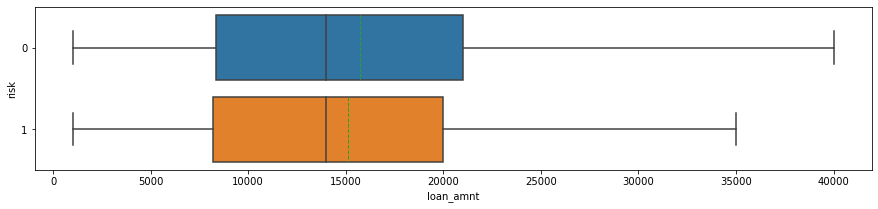

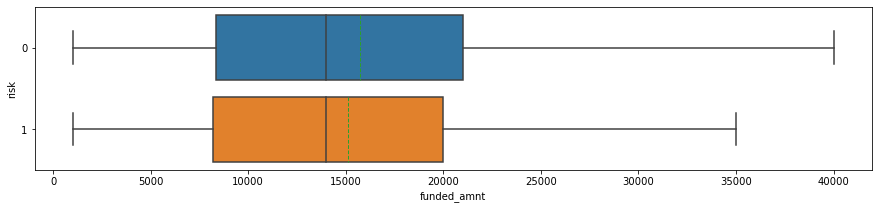

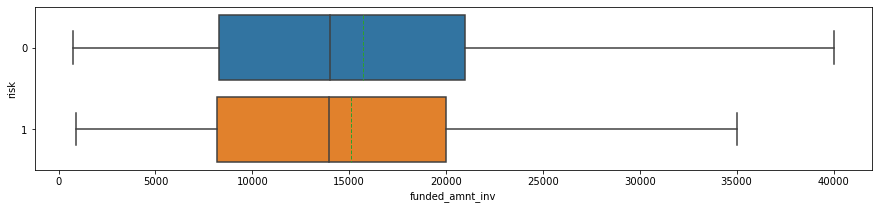

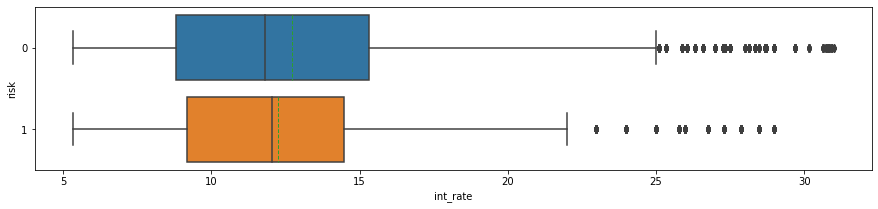

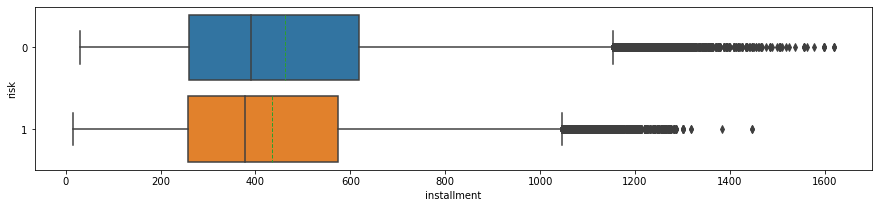

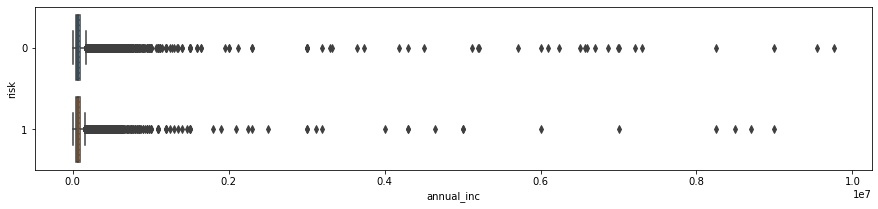

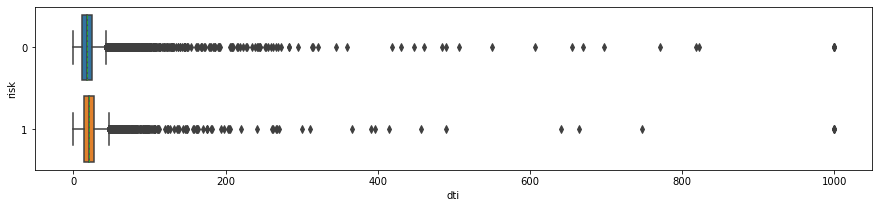

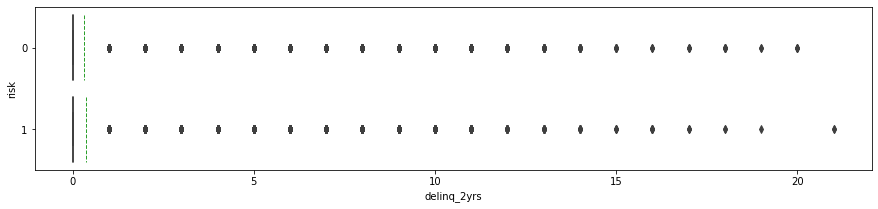

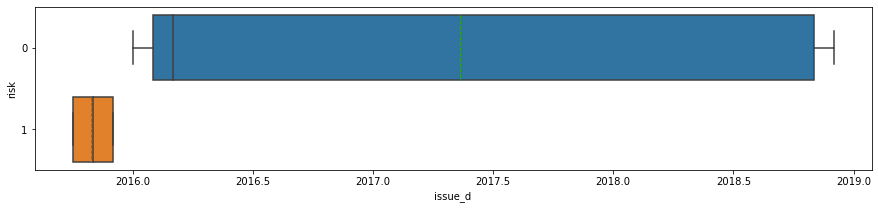

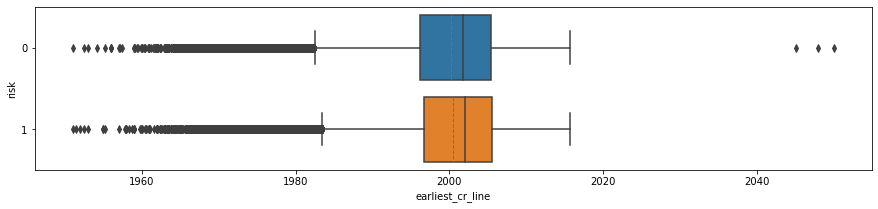

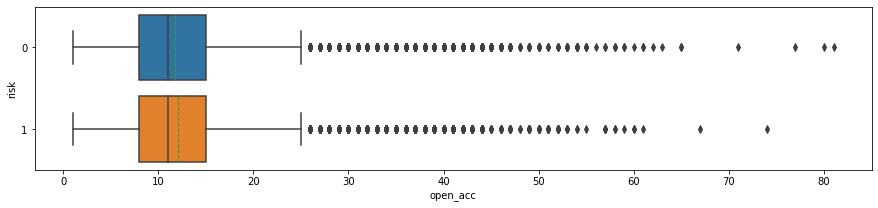

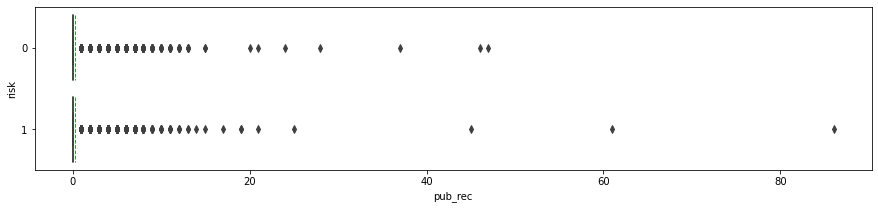

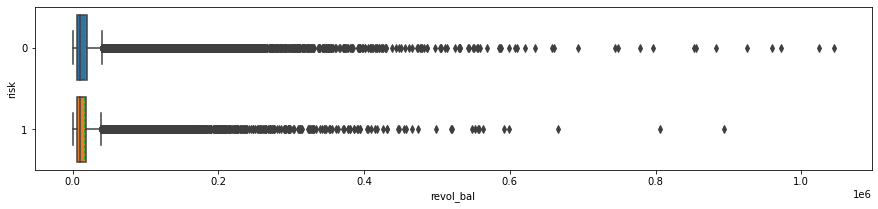

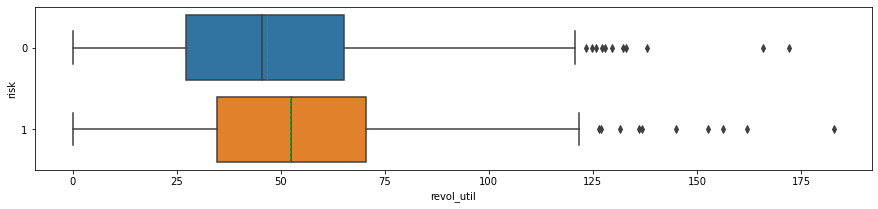

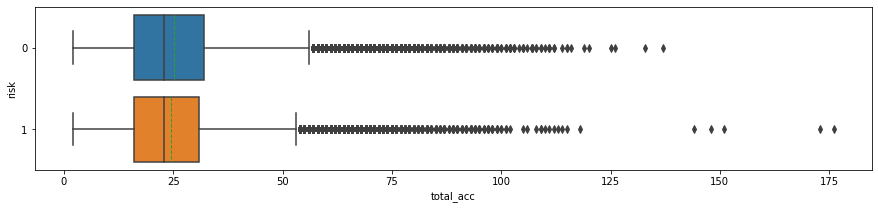

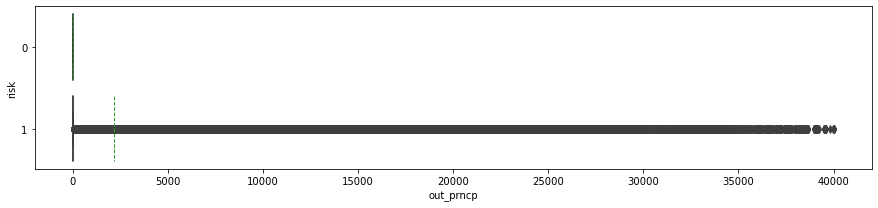

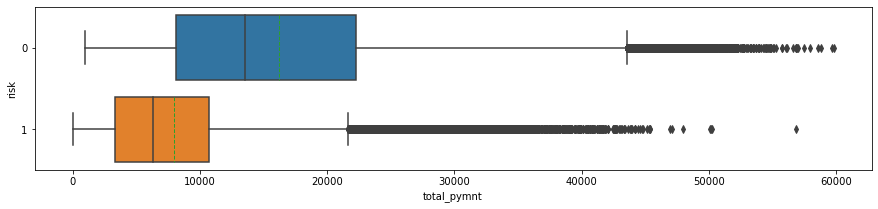

In [26]:
for col in num_cols:
    plt.figure(figsize=(15, 3))
    sns.boxplot(y=df.risk, x=df[col], showmeans=True, meanline=True, orient='h')

*У клиентов с риском дефолта в среднем меньшая сумма платежей на сегодняшний день, есть непогашенная задолженность, выше коэффициент использования возобновляемой кредитной линии, больше открытых кредитных линий, выше ставка, меньше очередной платеж и выше dti*

*Почти по всем данным присутствуют выбросы. Пока не будем их удалять, т.к. их очень большое количество.*

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000271AA372C70>,
      dtype=object)

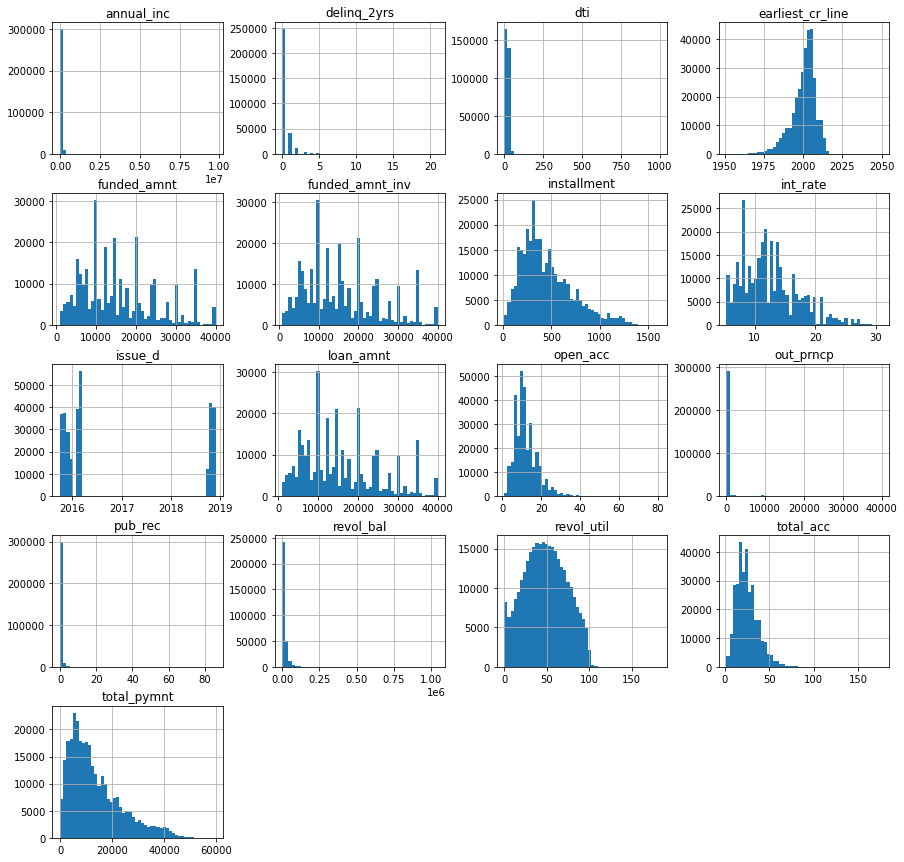

In [27]:
df[num_cols].hist(figsize=(15, 15), bins=50)

*Распределения всех переменных, кроме коэффициента использования возобновляемой кредитной линии и количества открытых кредитных линий, имеют смещения*

*Проведем корреляционный анализ*

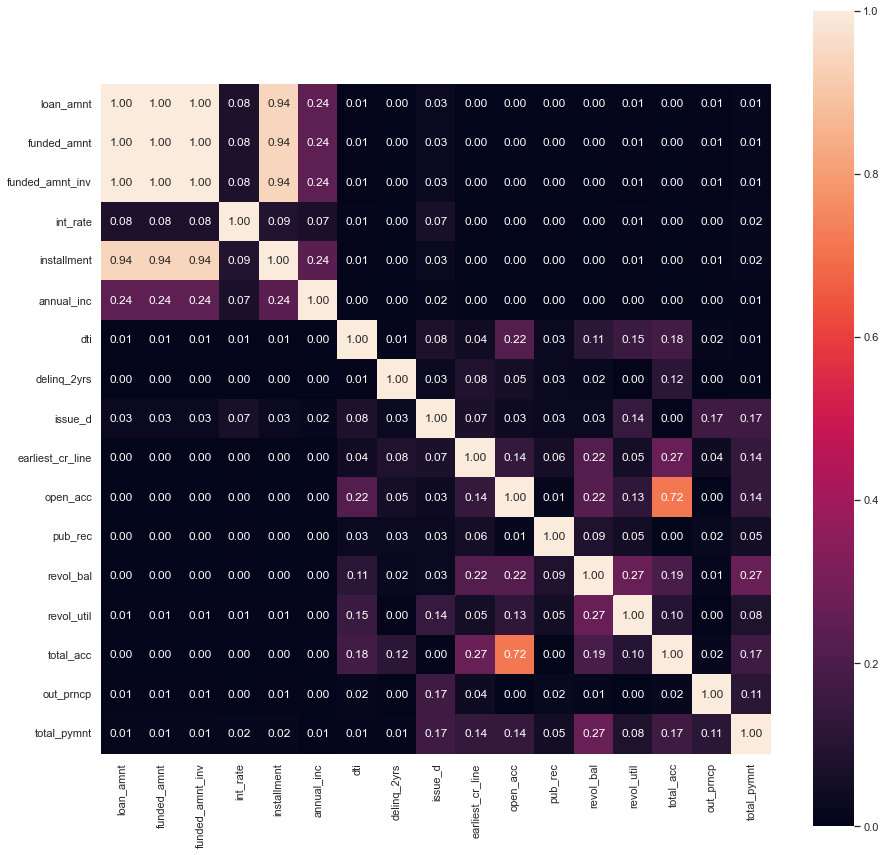

In [28]:
sns.set(font_scale = 1)
fig, axis = plt.subplots(figsize=(15,15))
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1, square=True, annot=True,
            fmt=".2f")

*Исходя из матрицы корреляции видно, что наблюдается сильная корреляция между признаками: loan_amnt и funded_amnt, funded_amnt_inv, installment; open_acc и total_acc.*

*Оценим значимость числовых признаков*

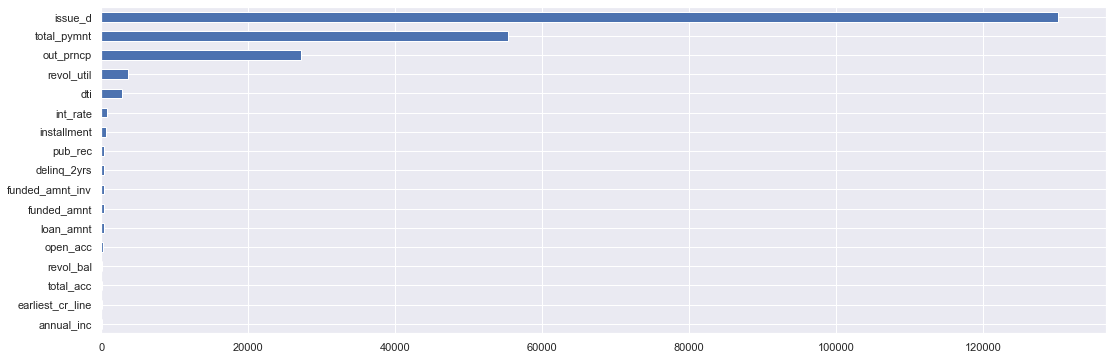

In [29]:
imp_num = pd.Series(f_classif(df[num_cols], df['risk'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
fig, ax = plt.subplots(figsize=(18, 6))
imp_num.plot(kind='barh')

*Оставим только наиболее значимые признаки, у которых не сильно выражена корреляция. Дату обращения также удалим.*

In [30]:
df = df.drop(['funded_amnt_inv','funded_amnt','loan_amnt','annual_inc','total_acc','issue_d','earliest_cr_line','revol_bal', 'id', 'open_acc'], axis = 1)

In [31]:
num_cols = ['int_rate','installment','dti','delinq_2yrs','pub_rec','revol_util','out_prncp','total_pymnt']

*Прологарифмируем данные для приближения распределения к нормальному*

In [32]:
for col in num_cols:
    df[col] = df[col].apply(lambda x: np.log(x + 2))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000271AB661580>,
      dtype=object)

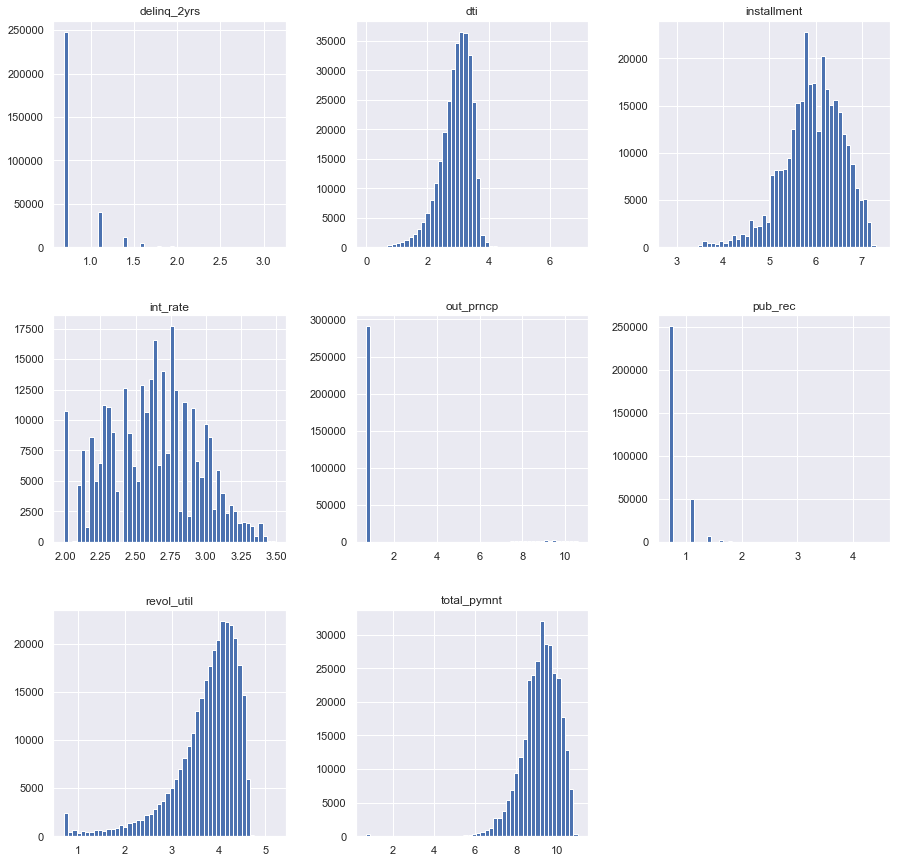

In [33]:
df[num_cols].hist(figsize=(15, 15), bins=50)

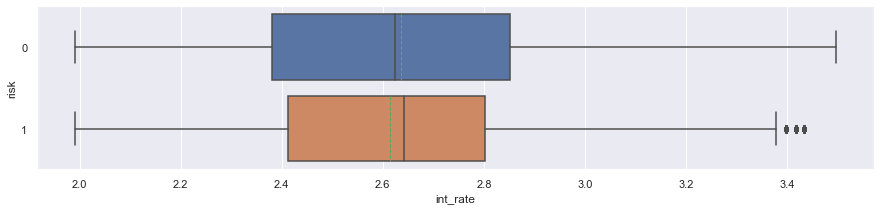

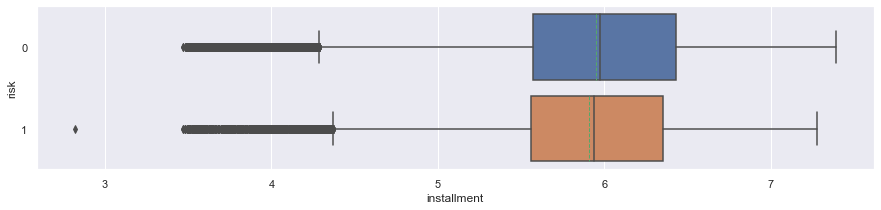

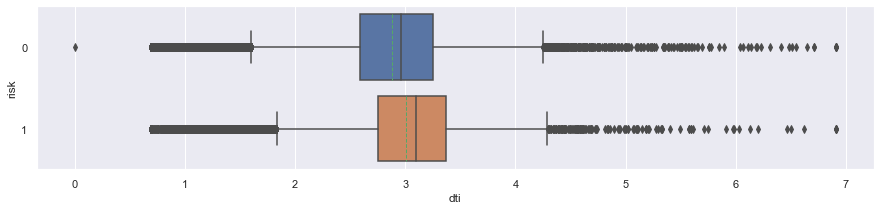

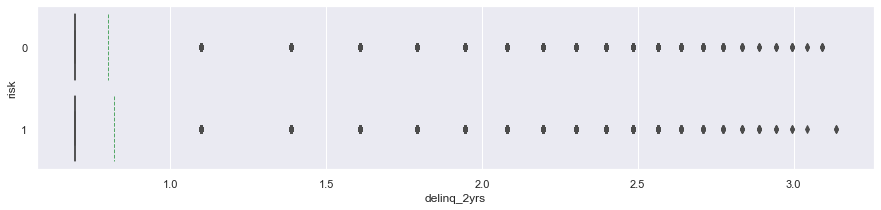

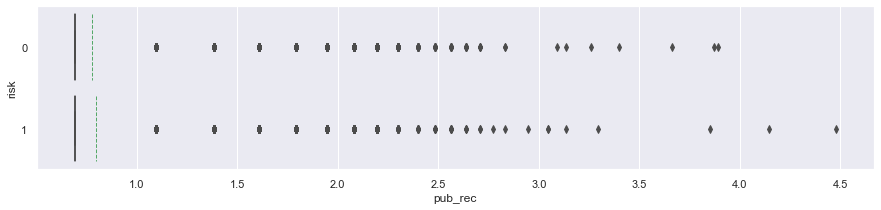

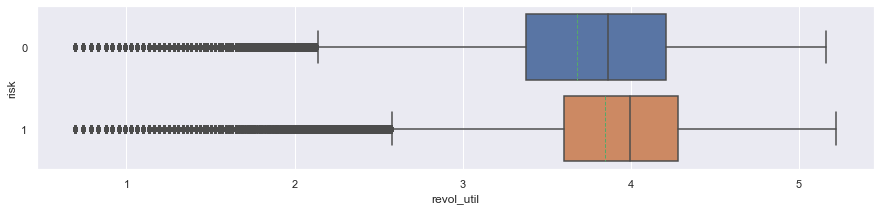

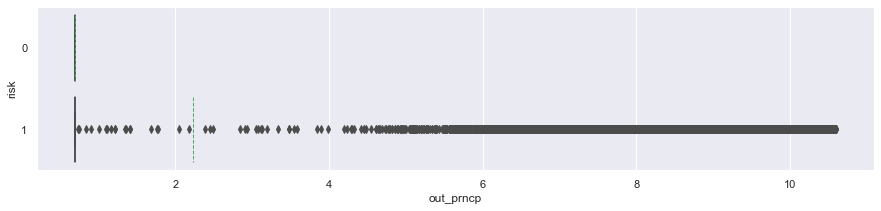

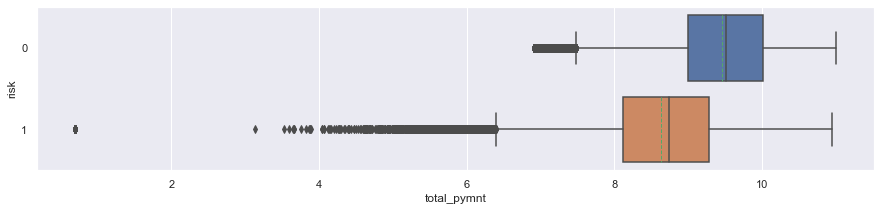

In [34]:
for col in num_cols:
    plt.figure(figsize=(15, 3))
    sns.boxplot(y=df.risk, x=df[col],
                showmeans=True, meanline=True, orient='h')

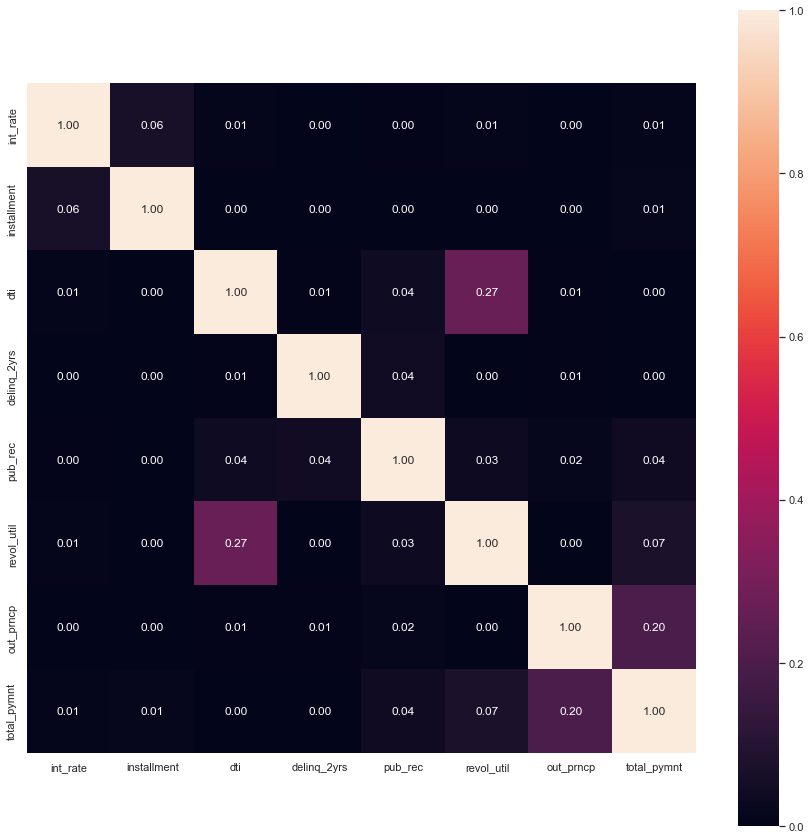

In [35]:
sns.set(font_scale = 1)
fig, axis = plt.subplots(figsize=(15,15))
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1, square=True, annot=True,fmt=".2f")

*Сильно коррелируют коэффициент использования кредитной линии и dti, непогашенная сумма основного долга и общая сумма платежей, поступившая на сегодняшний день.*

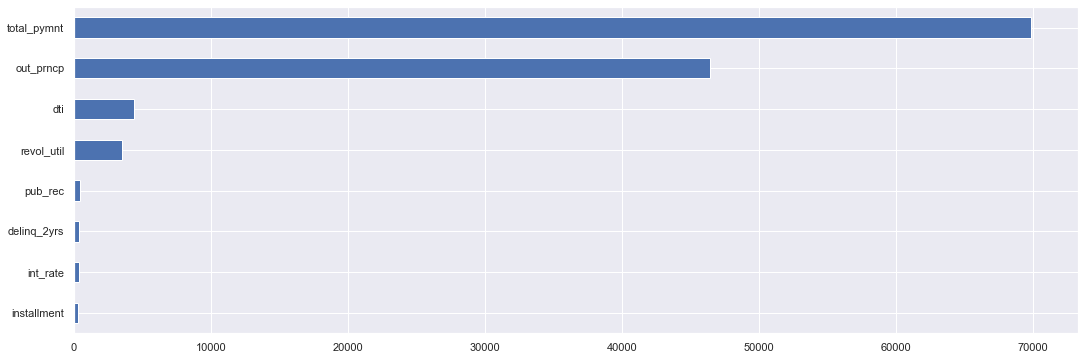

In [36]:
imp_num = pd.Series(f_classif(df[num_cols], df['risk'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
fig, ax = plt.subplots(figsize=(18, 6))
imp_num.plot(kind='barh')

*Оценив значимость, оставляем dti и общую сумму платежей, поступившую на сегодняшний день.*

In [37]:
df = df.drop(['out_prncp','revol_util'], axis = 1)

*Предобработка числовых данных завершена, перейдем к категориальным.*

In [38]:
label_encoder = LabelEncoder()
ct_cols = ['term','grade','emp_length','home_ownership','verification_status','purpose','addr_state','inq_last_6mths','loan_status','risk','is_title_known']
for column in ct_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
df.head()    

,term,int_rate,installment,grade,emp_length,home_ownership,verification_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,pub_rec,total_pymnt,loan_status,risk,is_title_known
0,0,2.744704,4.464988,2,1,3,0,2,4,3.480009,0.693147,0,1.098612,10.309900,2,0,1
1,1,3.041661,6.658306,3,1,1,1,1,34,3.961384,0.693147,0,0.693147,10.617875,2,0,1
2,0,2.994231,5.207791,3,6,1,1,1,46,3.040706,0.693147,0,0.693147,9.914318,2,0,1
3,0,3.041661,5.000652,3,1,1,1,1,42,1.893112,0.693147,0,0.693147,8.423150,2,0,1
4,1,2.898119,6.598209,2,1,1,0,1,18,2.665143,0.693147,0,0.693147,9.075339,2,0,1


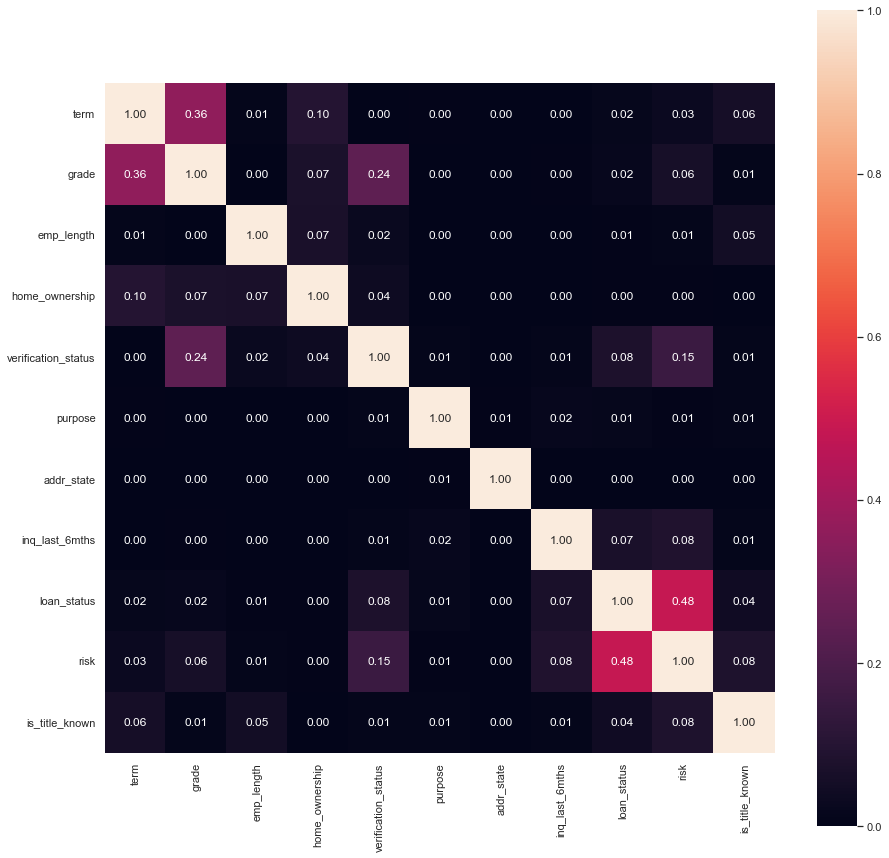

In [39]:
sns.set(font_scale = 1)
fig, axis = plt.subplots(figsize=(15,15))
sns.heatmap(df[ct_cols].corr().abs(), vmin=0, vmax=1, square=True, annot=True,fmt=".2f")

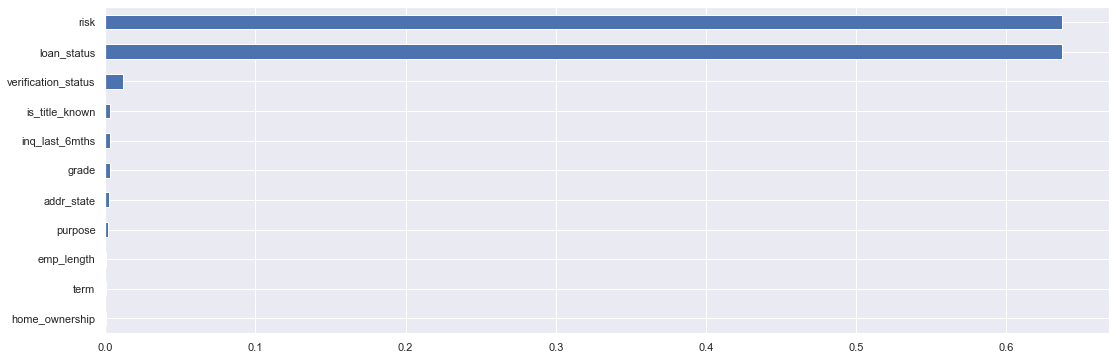

In [40]:
imp_cat = pd.Series(mutual_info_classif(df[ct_cols], df['risk'], discrete_features=True), index=ct_cols)
imp_cat.sort_values(inplace=True)
fig, ax = plt.subplots(figsize=(18, 6))
imp_cat.plot(kind='barh')

*Исключим колонки стаж, срок и вид собственности как не являющиеся значимыми. Статус займа исключим, т.к. данный признак сильно коррелирует с риском. Грейд исключим из-за сильной коррекляции со статусом верификации предоставленных данных.*

In [41]:
df = df.drop(['emp_length','term','home_ownership','grade','loan_status'], axis = 1)

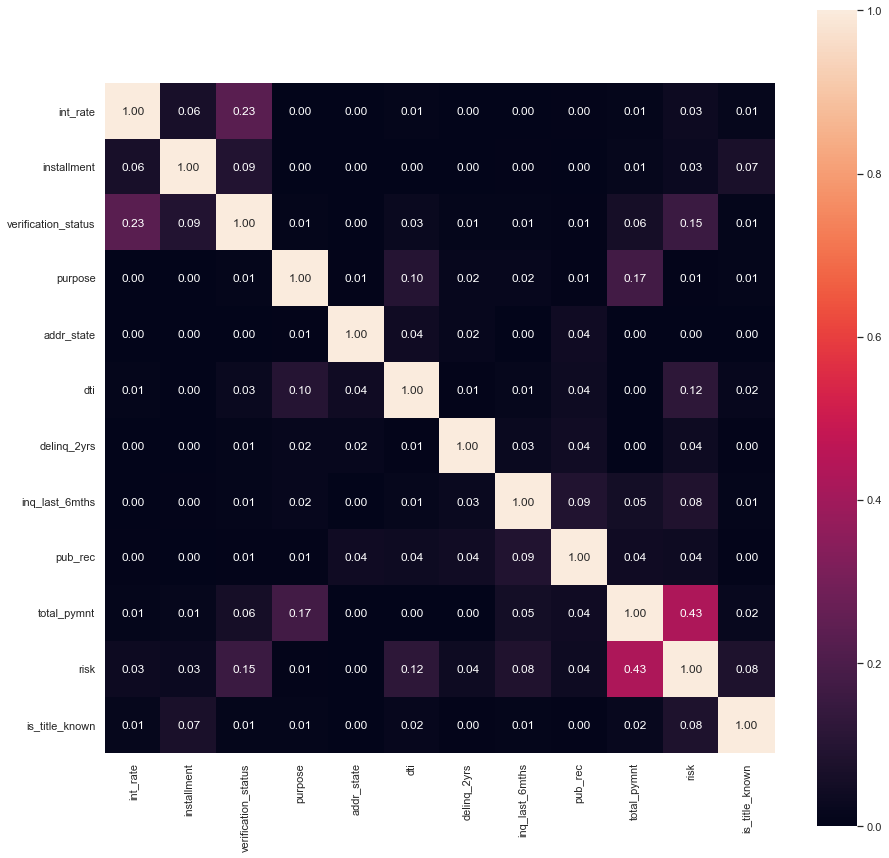

In [42]:
sns.set(font_scale = 1)
fig, axis = plt.subplots(figsize=(15,15))
sns.heatmap(df.corr().abs(), vmin=0, vmax=1, square=True, annot=True,fmt=".2f")

###### Построим модель логистической регрессии

In [43]:
X = df.drop(['risk'], axis=1)
y = df['risk'].values

import random
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random.seed())

lr = LogisticRegression(random_state=random.seed(), max_iter=1000)

lr.fit(X_train, y_train)

y_pred_proba = lr.predict_proba(X_test)[:, 1]
y_pred = lr.predict(X_test)

In [44]:
def all_metrics(y_true, y_pred, y_pred_proba):
    dict_metric = {}
    P = np.sum(y_true == 1)
    N = np.sum(y_true == 0)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 1) & (y_pred == 0))
    FN = np.sum((y_true == 0) & (y_pred == 1))

    dict_metric['P'] = [P, 'ЕСТЬ риск дефолта']
    dict_metric['N'] = [N, 'НЕТ риска дефолта']
    dict_metric['TP'] = [TP, 'Истинно дефолтные']
    dict_metric['TN'] = [TN, 'Истинно не-дефолтные']
    dict_metric['FP'] = [FP, 'Ложно дефолтные']
    dict_metric['FN'] = [FN, 'Ложно не-дефолтные']
    dict_metric['Accuracy'] = [accuracy_score(y_true, y_pred), 'Доля верно определённых']
    dict_metric['Precision'] = [precision_score(y_true, y_pred), 'Точность определения']
    dict_metric['Recall'] = [recall_score(y_true, y_pred), 'Полнота определения']
    dict_metric['F1-score'] = [f1_score(y_true, y_pred),'Среднее гармоническое Precision и Recall']
    dict_metric['ROC_AUC'] = [roc_auc_score(y_true, y_pred_proba), 'ROC-AUC']

    temp_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=['Значение', 'Описание метрики'])
    display(temp_df)

In [45]:
def show_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], label='Случайный классификатор', linestyle='--')
    plt.plot(fpr, tpr, label='Логистическая регрессия')
    plt.title('Логистическая регрессия ROC AUC = %0.3f' %roc_auc_score(y_true, y_pred_proba))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

In [46]:
def show_confusion_matrix(y_true, y_pred):
    color_text = plt.get_cmap('PuBu')(0.95)
    class_names = ['ЕСТЬ риск дефолта', 'НЕТ риска дефолта']
    cm = confusion_matrix(y_true, y_pred)
    cm[0, 0], cm[1, 1] = cm[1, 1], cm[0, 0]
    df = pd.DataFrame(cm, index=class_names, columns=class_names)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), title="Матрица ошибок")
    ax.title.set_fontsize(15)
    sns.heatmap(df, square=True, annot=True, fmt="d", linewidths=1, cmap="PuBu")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize=12)
    ax.set_ylabel('Предсказанные значения', fontsize=14, color=color_text)
    ax.set_xlabel('Реальные значения', fontsize=14, color=color_text)
    b, t = plt.ylim()
    plt.ylim(b+0.5, t-0.5)
    fig.tight_layout()
    plt.show()

,Значение,Описание метрики
P,20781.000000,ЕСТЬ риск дефолта
N,41288.000000,НЕТ риска дефолта
TP,9946.000000,Истинно дефолтные
TN,36691.000000,Истинно не-дефолтные
FP,10835.000000,Ложно дефолтные
FN,4597.000000,Ложно не-дефолтные
Accuracy,0.751373,Доля верно определённых
Precision,0.683903,Точность определения
Recall,0.478610,Полнота определения
F1-score,0.563130,Среднее гармоническое Precision и Recall


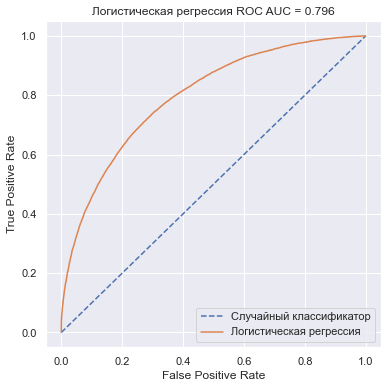

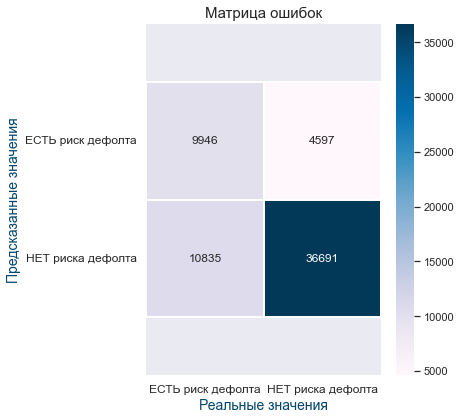

In [47]:
all_metrics(y_test, y_pred, y_pred_proba)
show_roc_curve(y_test, y_pred_proba)
show_confusion_matrix(y_test, y_pred)

*Нужно повысить качество модели, особенно по дефолтным клиентам*

In [48]:
df.groupby('risk').count()

,int_rate,installment,verification_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,pub_rec,total_pymnt,is_title_known
risk,,,,,,,,,,,
0,206772,206772,206772,206772,206772,206772,206772,206772,206772,206772,206772
1,103570,103570,103570,103570,103570,103570,103570,103570,103570,103570,103570


*Нужно сбалансировать выборку*

In [49]:
df1 = df[df['risk'] == 0].sample(frac =.50)

In [50]:
df2 = df[df['risk'] == 1]

In [51]:
df = pd.concat([df1, df2])

In [52]:
ct_cols = ['verification_status','purpose','addr_state','inq_last_6mths']
bn_cols = ['is_title_known']
X_cat = OneHotEncoder(sparse=False).fit_transform(df[ct_cols].values)

In [53]:
num_cols = ['int_rate','installment','dti','delinq_2yrs','pub_rec','total_pymnt']
X_num = StandardScaler().fit_transform(df[num_cols].values)

In [54]:
X = np.hstack([X_num, df[bn_cols].values, X_cat])
y = df['risk'].values

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random.seed())

lr = LogisticRegression(random_state=random.seed(), max_iter=1000)

lr.fit(X_train, y_train)

y_pred_proba = lr.predict_proba(X_test)[:, 1]
y_pred = lr.predict(X_test)

,Значение,Описание метрики
P,20691.000000,ЕСТЬ риск дефолта
N,20701.000000,НЕТ риска дефолта
TP,14680.000000,Истинно дефолтные
TN,15277.000000,Истинно не-дефолтные
FP,6011.000000,Ложно дефолтные
FN,5424.000000,Ложно не-дефолтные
Accuracy,0.723739,Доля верно определённых
Precision,0.730203,Точность определения
Recall,0.709487,Полнота определения
F1-score,0.719696,Среднее гармоническое Precision и Recall


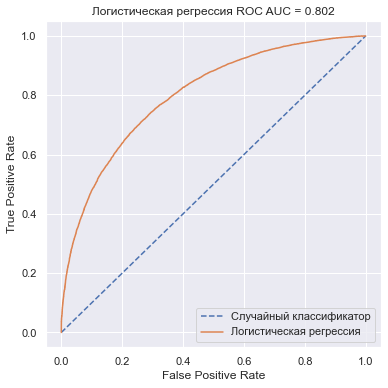

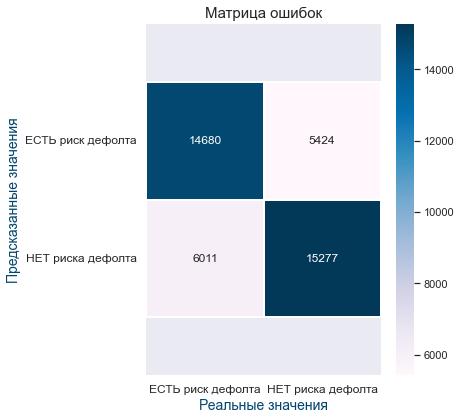

In [56]:
all_metrics(y_test, y_pred, y_pred_proba)
show_roc_curve(y_test, y_pred_proba)
show_confusion_matrix(y_test, y_pred)

###### Проблемы решения и пути развития

1. Указанные решения оторваны от бизнеса и не позволяют оценить величину рисков в абсолютном выражении, что вытекает в величину затрат на отделы и процессы связанные с решением вопросов риска.

2. Указанные решения не позволяют спланировать и оценить нагрузку, показатели и KPI отделов, связанных с решением вопросов риска.

3. Указанные решения не позволяют проактивно оценить кредитные активы банка и финансовые показатели.

4. Указанные решения не позволяют проактивно реагировать на потенциальные будущие угрозы в связи с изменением факторов.